In [1]:
import numpy as np

In [2]:
class Module():
    def __init__(self):
        self._train = True
    
    def forward(self, input):
        raise NotImplementedError

    def backward(self,input, grad_output):
        raise NotImplementedError
    
    def parameters(self):
        'Возвращает список собственных параметров.'
        return []
    
    def grad_parameters(self):
        'Возвращает список тензоров-градиентов для своих параметров.'
        return []
    
    def train(self):
        self._train = True
    
    def eval(self):
        self._train = False

In [3]:
class Sequential(Module):
    def __init__ (self, *layers):
        super().__init__()
        self.layers = layers

    def forward(self, input):
        res = input
        for layer in self.layers:
            res = layer.forward(res)
        self.output =res
        return res
        """
        Прогоните данные последовательно по всем слоям:
        
            y[0] = layers[0].forward(input)
            y[1] = layers[1].forward(y_0)
            ...
            output = module[n-1].forward(y[n-2])   
            
        Это должен быть просто небольшой цикл: for layer in layers...
        
        Хранить выводы ещё раз не надо: они сохраняются внутри слоев после forward.
        """

    def backward(self, input, grad_output):
        g=grad_output
        for i in range(len(self.layers)-1,0,-1):
            g=self.layers[i].backward(self.layers[i-1].output, g)#???
            
        grad_input = self.layers[0].backward(input, g)
            
        """
        Backward -- это как forward, только наоборот. (с)
        
        Предназначение backward:
        1. посчитать посчитать градиенты для собственных параметров
        2. передать градиент относительно своего входа
        
        О своих параметрах модули сами позаботятся. Нам же нужно позаботиться о передачи градиента.
         
            g[n-1] = layers[n-1].backward(y[n-2], grad_output)
            g[n-2] = layers[n-2].backward(y[n-3], g[n-1])
            ...
            g[1] = layers[1].backward(y[0], g[2])   
            grad_input = layers[0].backward(input, g[1])
        
        Тут цикл будет уже чуть посложнее.
        """
        
        return grad_input
      
    def parameters(self):
        'Можно просто сконкатенировать все параметры в один список.'
        return np.array([l.parameters() for l in self.layers])
    
    def grad_parameters(self):
        'Можно просто сконкатенировать все градиенты в один список.'
        return np.array([l.grad_parameters() for l in self.layers])
    
    def train(self):
        for layer in layers:
            layer.train()
    
    def eval(self):
        for layer in self.layers:
            print( layer.eval() )
            

In [4]:
class Linear(Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
       
        # на самом деле, очень важно, как оно инициализируется
        # если поставить всё нулями, то оно будет сходиться очень долго
        # но подробнее об этом -- в другой раз
#         stdv = 1./np.sqrt(dim_in)
        self.W = np.random.uniform(-1, 1, size=(dim_in, dim_out))
        self.b = np.random.uniform(-1, 1, size=dim_out)
        
    def forward(self, input):
        #Y=w*X+b
        self.output = np.dot(input, self.W) + self.b
        return self.output
    
    def backward(self, input, grad_output):

        self.grad_b = np.mean(grad_output, axis=0)
        self.grad_W = np.dot(input.T, grad_output)
        try:
            grad_input = np.dot(grad_output, self.W.T)
        except Exception as e:
            print(grad_output)
            raise e
        return grad_input
        
    def parameters(self):
        return [self.W, self.b]
    
    def grad_parameters(self):
        return [self.grad_W, self.grad_b]

In [340]:
import math
class Sigmoid(Module):
    def __init__(self, slope=0.03):
        super().__init__()

    def forward(self, input):
        print(input.shape)
        self.output = 1/(1+2.718**(-1*input))
        return self.output
    
    def backward(self, input, grad_output):

        grad_input = (1/(1+2.718**(-1*grad_output)))*(1-1/(1+2.718**(-1*grad_output)))

            
        return grad_input

In [341]:
class ReLU(Module):
    def __init__(self):
         super().__init__()
    
    def forward(self, input):
        self.output = np.maximum(input, 0)
        return self.output
    
    def backward(self, input, grad_output):
        grad_input = np.multiply(grad_output, input > 0)
        return grad_input

#### Metric

In [342]:
class Criterion():        
    def forward(self, input, target):
        raise NotImplementedError

    def backward(self, input, target):
        raise NotImplementedError

In [343]:
class MSE(Criterion):
    def forward(self, input, target):
        batch_size = input.shape[0]
        self.output = np.sum((input - target)**2) / batch_size
        return self.output
 
    def backward(self, input, target):
        self.grad_output  = (input - target.reshape(input.shape)) * 2 / input.shape[0]
        return self.grad_output

In [344]:
def SGD(model, lr=1e-3,mv=1):    
    for i in range(len(model.parameters() ) ):
        if(len(model.parameters()[i])==0):
            continue
        n0 , n1=(lr * model.grad_parameters()[i][0]) ,(lr * model.grad_parameters()[i][1])
#         n0[n0<-mv] = -mv
#         n1[n1<-mv] = -mv
#         n0[n0>mv] = mv
#         n1[n1>mv] = mv
        model.parameters()[i][0] -= n0#W
        model.parameters()[i][1] -= n1#b 

NN

In [345]:
def loader(X, Y, batch_size):    
    n = X.shape[0]

    # в начале каждой эпохи будем всё перемешивать
    # важно, что мы пермешиваем индексы, а не X
    indices = np.arange(n)
    np.random.shuffle(indices)
    
    for start in range(0, n, batch_size):
        # в конце нам, возможно, нужно взять неполный батч
        end = min(start + batch_size, n)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [346]:
import pandas as pd

In [347]:
mnist=pd.read_csv('mnist_test.csv')

In [348]:
Y=mnist.label
X=mnist.drop(['label'],axis=1)
X=X.values
Y=Y.values
X=X/255
# Y=Y/10
Y=Y.reshape(Y.shape[0],1)

In [358]:
def makear(a):
    m=np.zeros(10)
    m[a]=1
    return m
    
Y=np.apply_along_axis( lambda x: makear(x[0]), 1, Y)

In [359]:
model = Sequential(
    Linear(784, 256),
    ReLU(),
#     Linear(256, 256),
#     ReLU(),
#     Linear(256, 128),
#     ReLU(),
    Linear(256, 64),
    ReLU(),
    Linear(64, 10),
    Sigmoid()
#     Linear(2, 12),
#     Linear(2, 12),

)

criterion = MSE()

In [360]:
x1,y1 = X[:3],Y[:3]

In [368]:
y_pred = model.forward(x1)
loss = criterion.forward(y_pred, y1)
grad = criterion.backward(y_pred, y1)
loss

(3, 10)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in power
  


1.0

In [369]:
model.backward(x1,grad)
grad

array([[ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000, -6.66666667e-001,  0.00000000e+000,
         0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000, -6.66666667e-001,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000],
       [ 0.00000000e+000, -6.66666667e-001,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         1.52627232e-262,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000]])

In [370]:
SGD(model,0.01)

In [373]:
y_pred.mean()

7.6313615832943e-264

In [339]:
y_pred = model.forward(x1)
loss = criterion.forward(y_pred, y1)
grad = criterion.backward(y_pred, y1)
model.backward(x1, grad)
SGD(model,0.01)
y_pred.mean()

(3, 10)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in power
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in power
  del sys.path[0]


0.5000000000000007

In [109]:
import matplotlib.pyplot as plt
%matplotlib inline

In [116]:
epochs = 22
batch_size = 16
learning_rate = 1e-3

1.7500000000000002


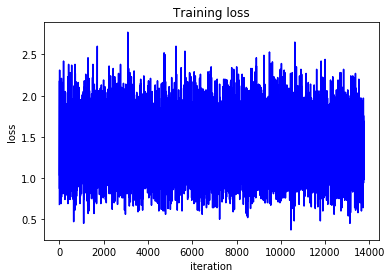

In [117]:
history = []
for i in range(epochs):
    for a, b in loader(X, Y, batch_size):
        # forward -- считаем все значения до функции потерь
        y_pred = model.forward(a)
        loss = criterion.forward(y_pred, b)
    
        # backward -- считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, b)
        grad = grad.reshape(grad.shape[0],1)
        model.backward(a, grad)
        
        # обновляем веса
        SGD(model,learning_rate)
        
        history.append(loss)
    
    
print(loss)
    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

In [126]:
 model.parameters()

array([list([array([[ 0.89523568,  0.34077811, -0.61938827, ...,  0.92182382,
         0.44200251,  0.21020758],
       [-0.8869723 ,  0.5639615 ,  0.71073102, ..., -0.02177151,
        -0.710613  ,  0.91927743],
       [-0.17249945, -0.39375679,  0.92150007, ..., -0.68004977,
         0.87915553,  0.23605116],
       ...,
       [ 0.5619148 ,  0.60043816, -0.76741329, ...,  0.85357053,
         0.24487993,  0.16314682],
       [-0.82470527, -0.54760958,  0.49911789, ...,  0.14193157,
        -0.21593998, -0.28226508],
       [ 0.39529918, -0.50289854,  0.0421823 , ...,  0.77073979,
         0.57212874, -0.02506827]]), array([ 3.03536917e-02, -9.64830482e-01, -4.20178763e-01, -8.28764765e-01,
        6.46210678e-01,  9.03783024e-01, -8.75685407e-01, -6.13413519e-01,
        8.98291292e-01,  1.06198188e-01, -1.00187785e+00, -4.13809529e-02,
        6.47938955e-01, -4.17568359e-01,  6.99334138e-01,  3.18268350e-01,
       -7.79764222e-01,  7.33009656e-01,  2.86172993e-01,  7.12000303e-01

In [130]:
a=[i for i in range(4)]

In [144]:
12,2,1,45

(12, 2, 1, 45)